In [2]:
import Pkg; Pkg.add("ForwardDiff")
import Pkg; Pkg.add("Optim")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
   Installed PositiveFactorizations ─ v0.2.4
   Installed Optim ────────────────── v1.11.0
    Updating `~/.julia/environments/v1.11/Project.toml`
  [429524aa] + Optim v1.11.0
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [429524aa] + Optim v1.11.0
  [85a6dd25] + PositiveFactorizations v0.2.4
Precompiling project...
    415.2 ms  ✓ PositiveFactorizations
   2069.7 ms  ✓ Optim
  2 dependencies successfully precompiled in 3 seconds. 405 already precompiled.


In [3]:
using Plots
using Optim
using LinearAlgebra
using ForwardDiff
using OrdinaryDiffEq

In [4]:
tiempos = collect(1780:5:1810)

7-element Vector{Int64}:
 1780
 1785
 1790
 1795
 1800
 1805
 1810

In [5]:
pop = [7721,7998,8415,8831,9287,9837,10488]*1000

7-element Vector{Int64}:
  7721000
  7998000
  8415000
  8831000
  9287000
  9837000
 10488000

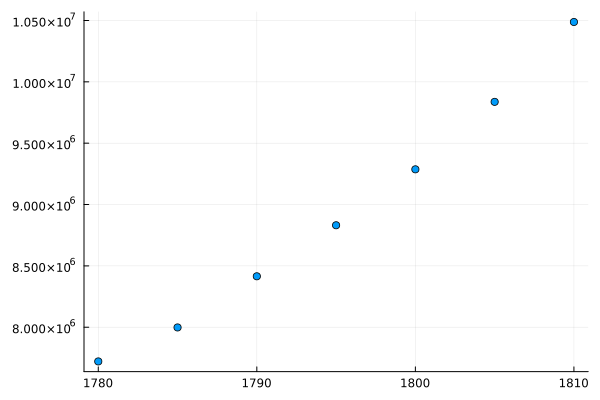

In [6]:
scatter(tiempos, pop, legend=false)

In [7]:
t0 = 1780
u0 = pop[1]

# P(t) -> modelo matemático de evolución de la población
# P(t) = P_0 * e ^r(t - t_0)
# P(t_2) = P_0 * e ^r(t_2 - t_0)
# P_2 = P_0 * e ^r(5)
# e ^(5r) = P_2 / P_0
# r = 1/5 * ln( P_2 / P_0 )
#

r = 1/5*log(pop[2]/u0)

0.0070495242195895815

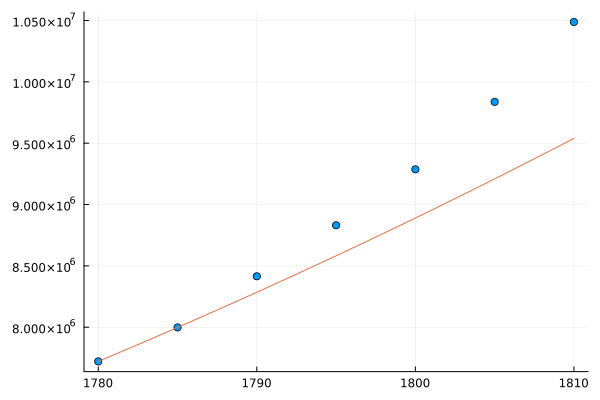

In [8]:


# Sin embargo, con esta solución exacta de r la función no se ajustan bien a los datos reales
# El objetivo será buscar la solución inicial u0 y los parámetros del problema p que mejor
# se ajusten a los valores reales.
#

tt = range(1780,1810,length=1000)
pp = @. u0*exp(r*(tt-t0))
plot!(tt,pp)

In [9]:
pop_ = @. u0*exp(r*(tiempos-t0)) 

7-element Vector{Float64}:
 7.721e6
 7.998e6
 8.284937702370159e6
 8.5821696339278e6
 8.890065112311168e6
 9.209006704865268e6
 9.53939070399073e6

In [10]:
sum((pop - pop_) .^2) # Suma de las diferencias al cuadrado

1.5306252326183074e12

### Minimización local de la función objetivo con el paquete Optim

In [11]:

# g(x) Función objetivo donde x = [uo, p]
#    u0 -> solución inicial
#    p  -> parámetros de P(t)
#
# Minimizar g(x)
function g(x)
    u0 = x[1]
    r = x[2]
    pop_ = @. u0*exp(r*(tiempos-t0)) 
    return sum((pop - pop_) .^2)
end


g (generic function with 1 method)

In [12]:
x0 = [u0,r]
g(x0)

1.5306252326183074e12

In [13]:
res = optimize(g,x0)

 * Status: success

 * Candidate solution
    Final objective value:     3.361258e+10

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    115
    f(x) calls:    249


In [14]:
x_opt = res.minimizer

2-element Vector{Float64}:
 7.611914570508355e6
 0.010358608934861693

In [15]:
g(x_opt)

3.3612584054958237e10

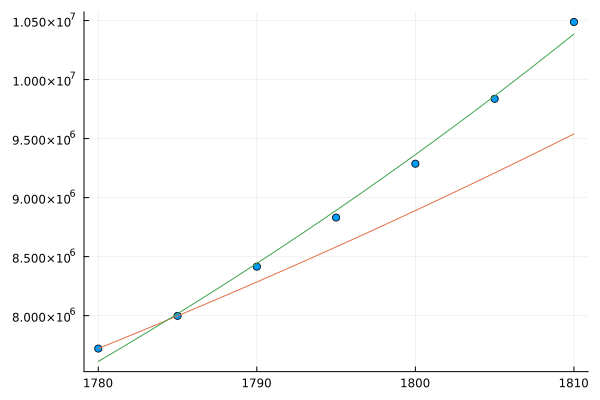

In [16]:
u0_opt = x_opt[1]
r_opt = x_opt[2]
pp = @. u0_opt*exp(r_opt*(tt-t0))
plot!(tt,pp)

### Implementación del gradiente de la función objetivo (derivación algorítmica)

Reescribimos la función objetivo:

In [17]:
function g_(x)
    u0 = x[1]
    r = x[2]
    m = length(tiempos)
    suma = 0.
    for j in 1:m
        expj = exp(r*(tiempos[j]-t0))
        popj = u0*expj
        difj = pop[j] - popj
        suma = suma + difj^2
    end
    return suma
end
  

g_ (generic function with 1 method)

Función gradiente:

In [18]:
function gradg(x)
    u0 = x[1]
    r = x[2]
    m = length(tiempos)
    Du0 = [1.,0.] 
    Dr = [0.,1.]
    suma = 0.
    Dsuma = [0.,0.]
    for j in 1:m
        k = tiempos[j]-t0
        expj = exp(r*k)
        Dexpj = k*expj*Dr
        popj = u0*expj
        Dpopj = expj*Du0 + u0*Dexpj
        difj = pop[j] - popj
        Ddifj = -Dpopj
        # suma = suma + difj^2
        Dsuma = Dsuma + 2*difj*Ddifj
    end
    return Dsuma
end
  

gradg (generic function with 1 method)

#### Comprobación

In [19]:
# x = BigFloat.(2*rand(2) .- 1)
# v = BigFloat.(2*rand(2) .- 1)
x = (2*rand(2) .- 1)
v = (2*rand(2) .- 1)
epsilon = 1e-12
(g(x + epsilon*v) - g(x - epsilon*v))/(2*epsilon)

8.82760704e20

In [20]:
dot(gradg(x),v)

8.827680058945866e20

#### Comparación de los gradientes en x0 y x_opt

In [21]:
gradg(x0)

2-element Vector{Float64}:
 -5.588444141295734e6
 -1.0588763781725028e15

In [22]:
gradg(x_opt)

2-element Vector{Float64}:
 -0.04340981901623309
 -1.077445109375e6

In [23]:
(g(x0), g(x_opt))

(1.5306252326183074e12, 3.3612584054958237e10)

#### Gradiente con el paquete ForwardDiff

In [24]:
ForwardDiff.gradient(g,x_opt)

2-element Vector{Float64}:
 -0.04340981901623309
 -1.077445109375e6

In [25]:
gradg(x_opt)

2-element Vector{Float64}:
 -0.04340981901623309
 -1.077445109375e6

In [26]:
G = similar(x_opt)
ForwardDiff.gradient!(G,g,x_opt)

2-element Vector{Float64}:
 -0.04340981901623309
 -1.077445109375e6

### Minimización local con función gradiente

In [27]:
function gradg!(G,x)
    ForwardDiff.gradient!(G,g,x)
    return nothing
end


gradg! (generic function with 1 method)

In [28]:
# res_ = optimize(g,gradg!,BigFloat.(x0))
res_ = optimize(g, gradg!, x0)

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Final objective value:     3.361258e+10

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.73e-18 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.28e-25 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 7.34e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    11
    f(x) calls:    96
    ∇f(x) calls:   96


In [28]:
x_opt_ = res_.minimizer

2-element Vector{Float64}:
 7.611914578141671e6
 0.010358608893193802

#### Comparación con minimización anterior

In [29]:
(g(x_opt), g(x_opt_), g(x_opt)-g(x_opt_))

(3.3612584054958237e10, 3.361258405495859e10, -0.000354766845703125)

In [30]:
(norm(ForwardDiff.gradient(g,x_opt)), norm(ForwardDiff.gradient(g,x_opt_)))

(1.077445109375001e6, 0.734375)

El valor de la función apenas a bajado, pero la norma del graciente sí.

## Ajuste de populación inicial y valores de los parámetros de una generalización del modelo de Malthus

Modelo de Malthus generalizado:

$$ 
\frac{d}{dt} u = (r_0 + c (t-t_0)) \, u, \quad u(t_0) = u_0.
$$


In [31]:
function f(u,p,t)
    t0 = tiempos[1]
    r0 = p[1]
    c = p[2]
    return (r0 + c * (t-t0))*u
end

f (generic function with 1 method)

Nueva función objetivo:

In [32]:
tspan = (tiempos[1], tiempos[end])

h = 1/2
p = zeros(2)

function g2(X)
    u0 = X[1]
    p[1] = X[2]
    p[2] = X[3]
    prob = ODEProblem(f,u0,tspan,p)
    sol = solve(prob, RK4(), adaptive=false, dt = h, saveat=tiempos)
    pop_ = sol.u
    m = length(tiempos)
    suma = 0.
    for j in 1:m
        difj = pop[j] - pop_[j]
        suma = suma + difj^2
    end
    return suma
end
  

g2 (generic function with 1 method)

In [33]:
X0 = [x_opt_[1],  x_opt_[2], 0.]
Float64.([g(x_opt_), g2(X0)])

2-element Vector{Float64}:
 3.361258405495859e10
 3.3612584054958168e10

In [34]:
Float64.([g(BigFloat.(x_opt_)), g2(BigFloat.(X0))])

2-element Vector{Float64}:
 3.3612584054958668e10
 3.3612584054958668e10

### Ajuste paramétrico con Optim

In [1]:
res = optimize(g2, X0)

LoadError: UndefVarError: `optimize` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [36]:
X_opt = res.minimizer
(g2(X0),g2(X_opt))

(3.3612584054958168e10, 2.0236738241253664e9)

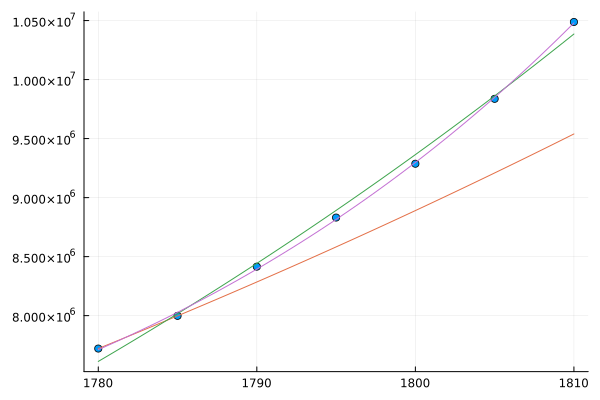

In [37]:
u0 = X_opt[1]
p[1] = X_opt[2]
p[2] = X_opt[3]
prob = ODEProblem(f,u0,tspan,p)
sol = solve(prob, RK4(), adaptive=false, dt = h, save_everystep=true)
plot!(sol.t, sol.u)